<a href="https://colab.research.google.com/github/benstream/CS-311/blob/main/AKFF_Data_Graphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import glob
import os
from matplotlib import colormaps
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import numpy as np

In [2]:
from google.colab import drive
from google.colab import data_table
data_table.enable_dataframe_formatter()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Set Drive to directitory and make sure CSV files are there\
%cd /content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical\ Data/Fire_Weather_Data/akff_data

%ls

/content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical Data/Fire_Weather_Data/akff_data
akff_data_combined.csv             FPKA2_akff_data.csv     O14KX_akff_data.csv  PAKF_akff_data.csv
ALSA2_akff_data.csv                KILA2_akff_data.csv     P17KX_akff_data.csv  PANW_akff_data.csv
BLAA2_akff_data.csv                KILA2_akff_data.gsheet  PADL_akff_data.csv   PAPH_akff_data.csv
CONA2_akff_data.csv                missing_data/           PAIG_akff_data.csv   PAPN_akff_data.csv
COVA2_akff_data.csv                MOGA2_akff_data.csv     PAIL_akff_data.csv   PASD_akff_data.csv
earliest_akff_data_by_station.csv  N15KX_akff_data.csv     PAJC_akff_data.csv   SVRA2_akff_data.csv
FAFA2_akff_data.csv                N18KX_akff_data.csv     PAJZ_akff_data.csv


In [4]:
# Define a function that returns zero if the value is negative, otherwise returns the value itself
def zero_if_negative(value):
    if value < 0:
        return 0
    else:
        return value

# Read in CSV File(s)
path = './' # use your path
all_files = glob.glob(os.path.join(path, "KILA2_akff_data.csv"))
df = pd.concat((pd.read_csv(f, comment='!',low_memory=False,usecols=['NAME','STATIONID','DATE','ATF','WSM','PREC','FWI','BUI'],parse_dates=['DATE']) for f in all_files), ignore_index=True)

# Create a list of months to filter (May-Sept)
months = [5, 6, 7, 8, 9]

# 5 year grouper based on timeframe, arbitrary origin date
yearGroup = pd.Grouper(key='DATE', freq='5Y', origin='1970-01-01',label='left')

# Combine files and sort by datetime, now data is ordered, removing rows that have no date, assigning dtypes.
#df['DATE'] = pd.to_datetime(df['DATE'],format = "%Y%m%d")
df.loc[:,'PREC'] = df.loc[:,'PREC'].to_numpy(float)
df.loc[:,'PREC'] = df['PREC'].apply(zero_if_negative)
df.loc[:,'WSM'] = df.loc[:,'WSM'].to_numpy(float)

# Calculate the rolling sum of the 'rain_diff' column with a window of 24 & 72 hours
df.loc[:,'day'] = df.loc[:,'DATE'].dt.dayofyear
df.loc[:,'year'] = df.loc[:,'DATE'].dt.year
df.loc[:,'rain_gain_24h'] = df.rolling('24H', on='DATE')['PREC'].sum()
df.loc[:,'rain_gain_72h'] = df.rolling('72H', on='DATE')['PREC'].sum()

# Filter the dataframe by the months after computations
df = df[df['DATE'].dt.month.isin(months)]

# Pivot the data by year and month
df_pivot = pd.pivot_table(df,index='day', columns=yearGroup, values='PREC').cumsum()
#df_pivot.fillna(method='ffill', inplace=True)

# Create Rolling Average for Max wind speed to oivot off of.

df_pivot_maxwind = pd.pivot_table(df,index='day', columns=yearGroup, values='WSM',aggfunc='max')

df_pivot_wind = pd.pivot_table(df,index='day', columns=yearGroup, values='WSM',aggfunc='mean')

# Create Rolling 72 Hour Average and Max wind speed
df.loc[:,'max_windspeed'] = df.rolling('3D', on='DATE')['WSM'].max()
df_pivot_maxwind_72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='max_windspeed')

df.loc[:,'mean_windspeed_72hr'] = df.rolling('3D', on='DATE',min_periods=3)['WSM'].mean()
df_pivot_wind_72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='mean_windspeed_72hr')

# Create the Pivots of rain averages
df_pivot_rain24hr = pd.pivot_table(df,index='day', columns=yearGroup, values='rain_gain_24h')
df_pivot_rain72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='rain_gain_72h')

# # Create average of solar radiation ((DSR NOT DIRECT SOLAR RADIATION))
# df.loc[:,'mean_solar_rad_24hr'] = df.rolling('1D', on='DATE')['DSR'].mean()
# df_pivot_solar = pd.pivot_table(df,index='day', columns=yearGroup, values='mean_solar_rad_24hr')

# Create average and max of Build Up Index

df_pivot_bui_mean = pd.pivot_table(df,index='day', columns=yearGroup, values='BUI')
df_pivot_bui_max = pd.pivot_table(df,index='day', columns=yearGroup, values='BUI',aggfunc='max')

# Create average and max of solar radiation

df_pivot_fwi = pd.pivot_table(df,index='day', columns=yearGroup, values='FWI')
df_pivot_fwi_max = pd.pivot_table(df,index='day', columns=yearGroup, values='FWI', aggfunc='max')


<ipython-input-4-3e5007f02941>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'max_windspeed'] = df.rolling('3D', on='DATE')['WSM'].max()


In [58]:
# Read in CSV File(s)
path = './' # use your path
all_files_stats = glob.glob(os.path.join(path, "*_data.csv"))
df_stats = pd.concat((pd.read_csv(f, comment='!',usecols=['NAME','STATIONID','DATE','ATF','FWI'],parse_dates=['DATE']) for f in all_files_stats), ignore_index=True)
df_stats.loc[:,'day'] = df.loc[:,'DATE'].dt.dayofyear
df_stats.loc[:,'year'] = df.loc[:,'DATE'].dt.year

df_stats


STATIONID                   NAME       DATE   ATF  FWI    day    year
0         KILA2                KILBUCK 1994-04-29  36.0  0.9    NaN     NaN
1         KILA2                KILBUCK 1994-04-30  36.0  0.9    NaN     NaN
2         KILA2                KILBUCK 1994-05-01  44.0  1.8  121.0  1994.0
3         KILA2                KILBUCK 1994-05-02  40.0  0.5  122.0  1994.0
4         KILA2                KILBUCK 1994-05-03  38.0  0.2  123.0  1994.0
...         ...                    ...        ...   ...  ...    ...     ...
60030     O14KX  Tigyukauivet Mountain 2023-10-27   NaN  NaN    NaN     NaN
60031     O14KX  Tigyukauivet Mountain 2023-10-28   NaN  NaN    NaN     NaN
60032     O14KX  Tigyukauivet Mountain 2023-10-29   NaN  NaN    NaN     NaN
60033     O14KX  Tigyukauivet Mountain 2023-10-30   NaN  NaN    NaN     NaN
60034     O14KX  Tigyukauivet Mountain 2023-10-31   NaN  NaN    NaN     NaN

[60035 rows x 7 columns]

In [62]:
# Calculate the percentage of non-missing values for each column
df_stats.count() / len(df_stats)

# Group the data by NAME and calculate the percentage of non-missing values for ATF and FWI within each group
df_stats['AFT_pct'] = 100 * df_stats.groupby('NAME')['ATF'].transform('count') / df_stats.groupby('NAME')['ATF'].transform('size')
df_stats['FWI_pct'] = 100 * df_stats.groupby('NAME')['FWI'].transform('count') / df_stats.groupby('NAME')['FWI'].transform('size')


# Pivot the data into a table with NAME as the index and AFT_pct and FWI_pct as the columns
df_stats_table = df_stats.pivot_table(index='STATIONID', values=['AFT_pct', 'FWI_pct'], aggfunc='mean')

df_stats_table




AFT_pct    FWI_pct
STATIONID                      
ALSA2      96.987495  72.300114
BLAA2      75.873656  24.798387
CONA2      97.459102  33.101288
COVA2      92.340992  34.065934
FAFA2      66.943798  11.539741
FPKA2      78.490832  17.630465
KILA2      89.546980  72.046980
MOGA2      61.986971  27.394137
N15KX      89.964789  33.758803
N18KX      92.766331  38.360368
O14KX      67.184035  18.847007
P17KX      91.062237  47.496490
PADL       98.975957  64.514693
PAIG       93.840890  41.274594
PAIL       98.958166  75.268473
PAJC       40.807175   0.000000
PAJZ       91.148325  37.320574
PAKF       61.918195  33.568406
PANW       91.873396  43.712575
PAPH       86.817326  39.359699
PAPN       92.655367  17.702448
PASD       99.858956  22.143865
SVRA2      92.804369  45.197559

In [61]:
# Yearly Plot Data

df_prec_yearly = pd.pivot_table(df,index='day', columns='year', values='PREC').cumsum()
#df_pivot.fillna(method='ffill', inplace=True)

# Create Rolling Average for Max wind speed to oivot off of.

df_maxwind_yearly = pd.pivot_table(df,index='day', columns='year', values='WSM',aggfunc='max')

df_wind_yearly = pd.pivot_table(df,index='day', columns='year', values='WSM',aggfunc='mean')

# Create Rolling 72 Hour Average and Max wind speed
df_maxwind_72hr_yearly = pd.pivot_table(df,index='day', columns='year', values='max_windspeed')

df_wind_72hr_yearly = pd.pivot_table(df,index='day', columns='year', values='mean_windspeed_72hr')

# Create the Pivots of rain averages
df_rain24hr_yearly = pd.pivot_table(df,index='day', columns='year', values='rain_gain_24h')
df_rain72hr_yearly = pd.pivot_table(df,index='day', columns='year', values='rain_gain_72h')

# # Create average of solar radiation ((DSR NOT DIRECT SOLAR RADIATION))
# df_solar_yearly = pd.pivot_table(df,index='day', columns='year', values='mean_solar_rad_24hr')

# Create average and max of Build Up Index

df_bui_mean_yearly = pd.pivot_table(df,index='day', columns='year', values='BUI')
df_bui_max_yearly = pd.pivot_table(df,index='day', columns='year', values='BUI',aggfunc='max')

# Create average and max of solar radiation

df_fwi_yearly = pd.pivot_table(df,index='day', columns='year', values='FWI')
df_fwi_max_yearly = pd.pivot_table(df,index='day', columns='year', values='FWI', aggfunc='max')

In [7]:
figsize=(16, 8)
nameID = (df.iloc[0].NAME,df.iloc[0].STATIONID)
legend =['1990-1995', '1995-2000', '2000-2005','2005-2010','2010-2015', '2015-2020','2020-']
columns = 4
colormap = "plasma"
lw = 3 #list(colormaps)

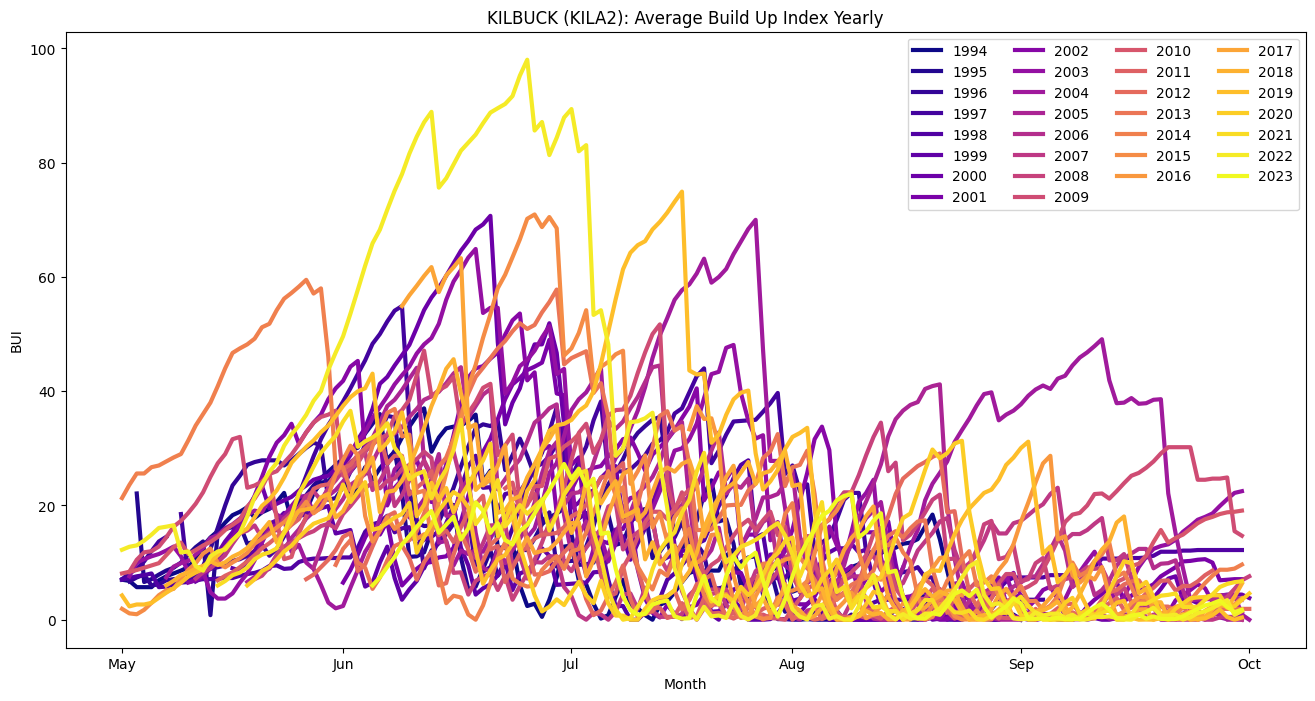

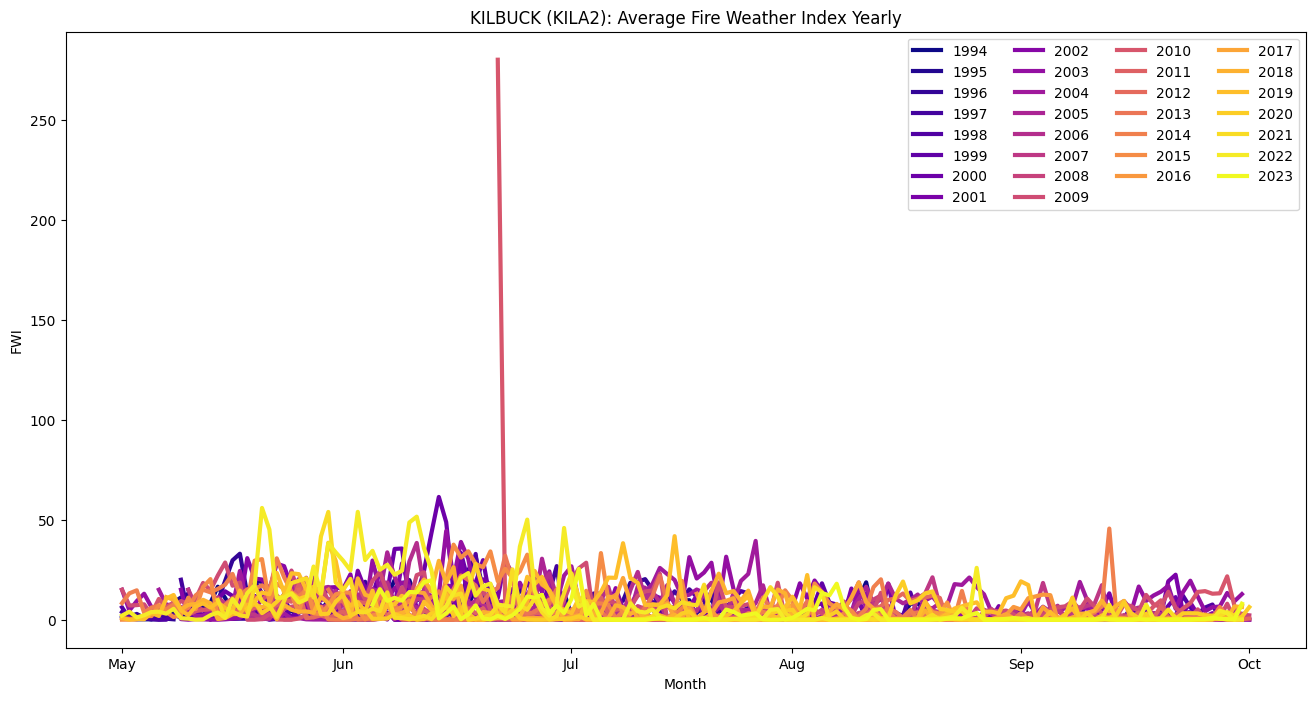

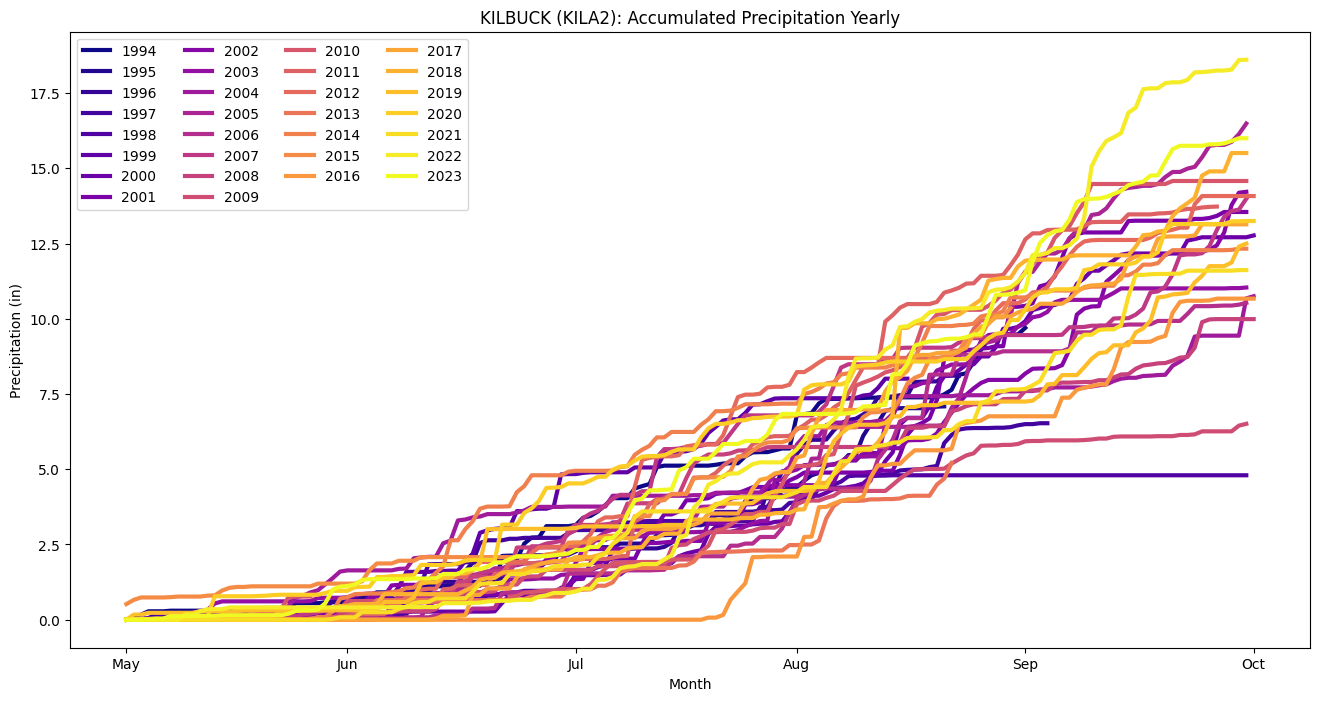

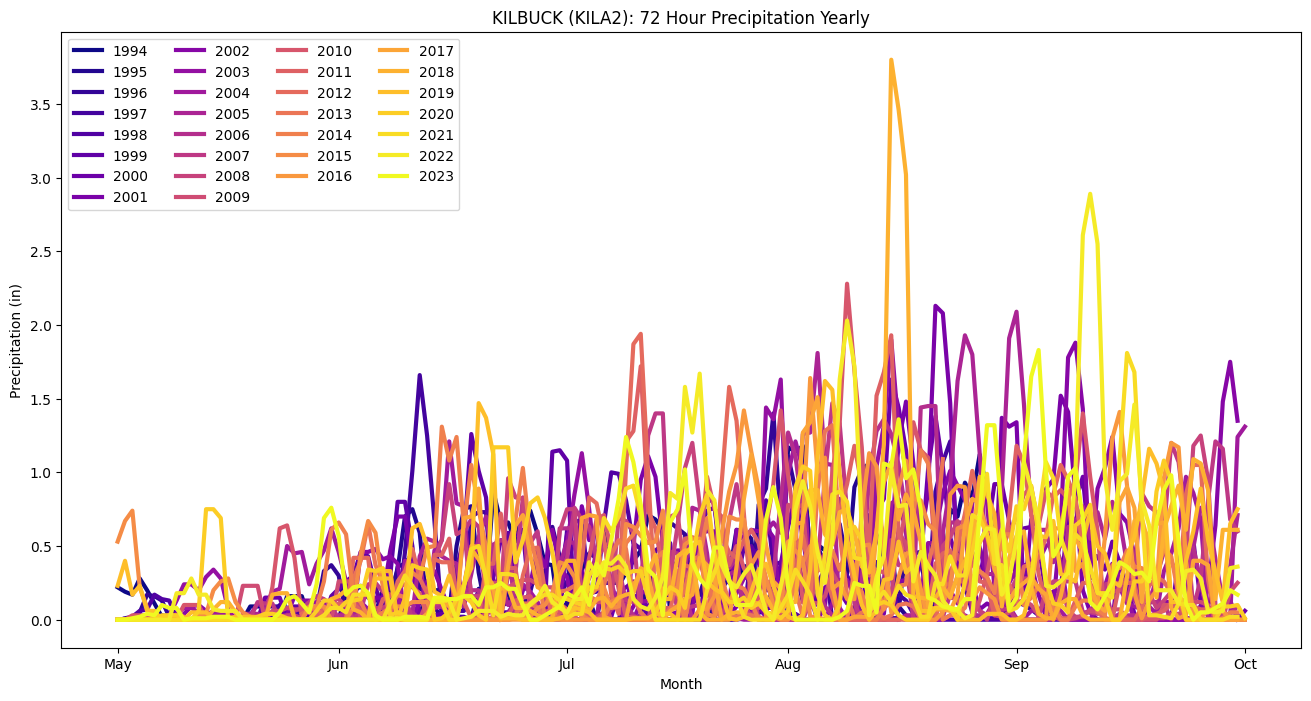

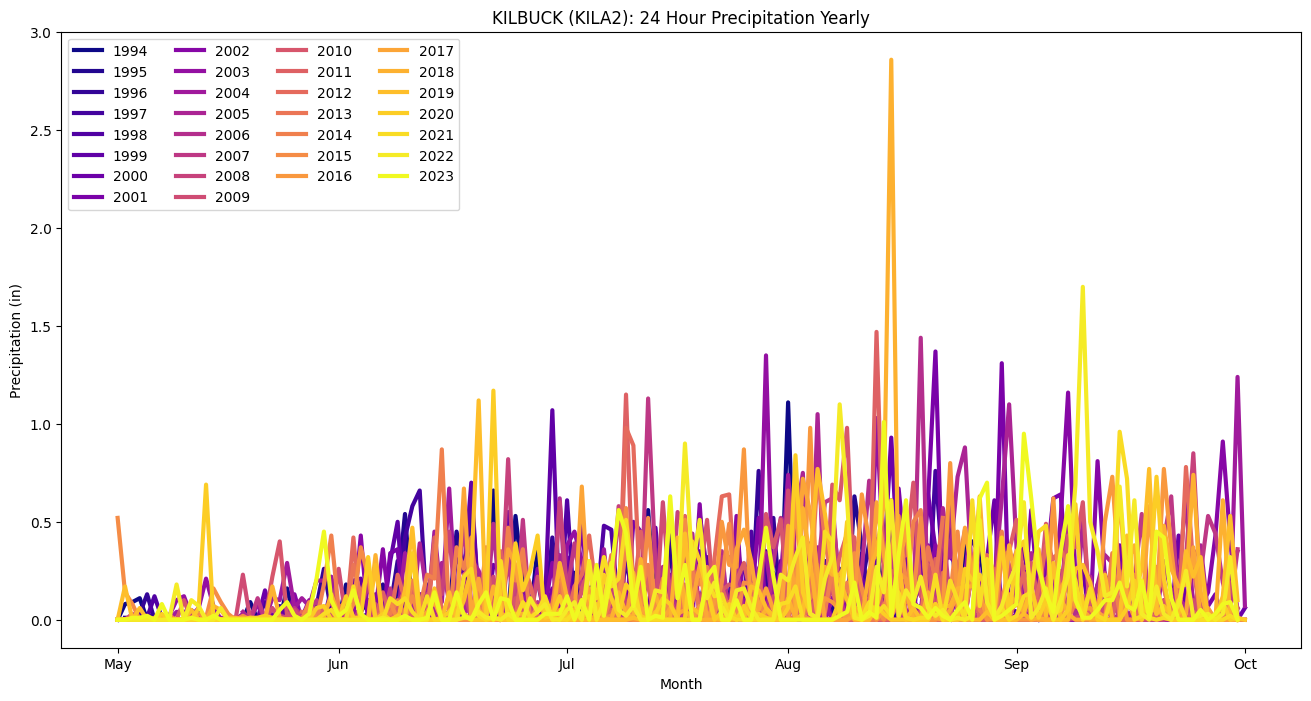

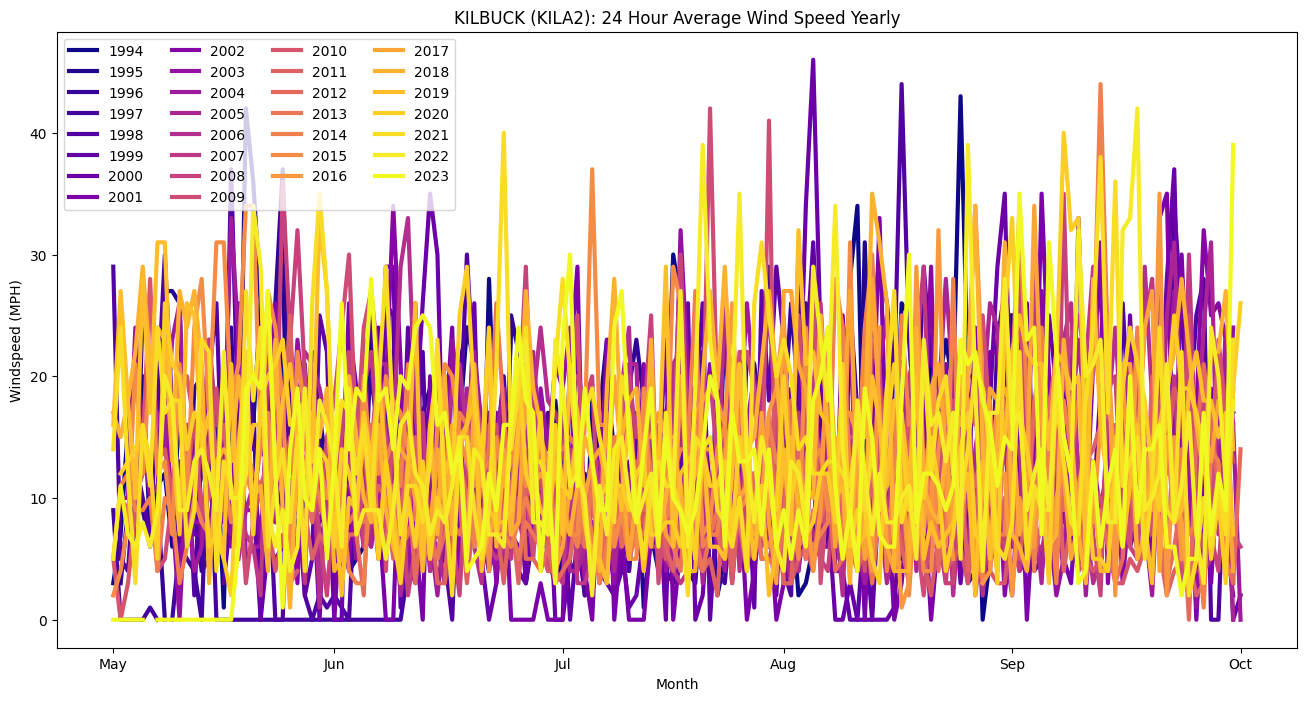

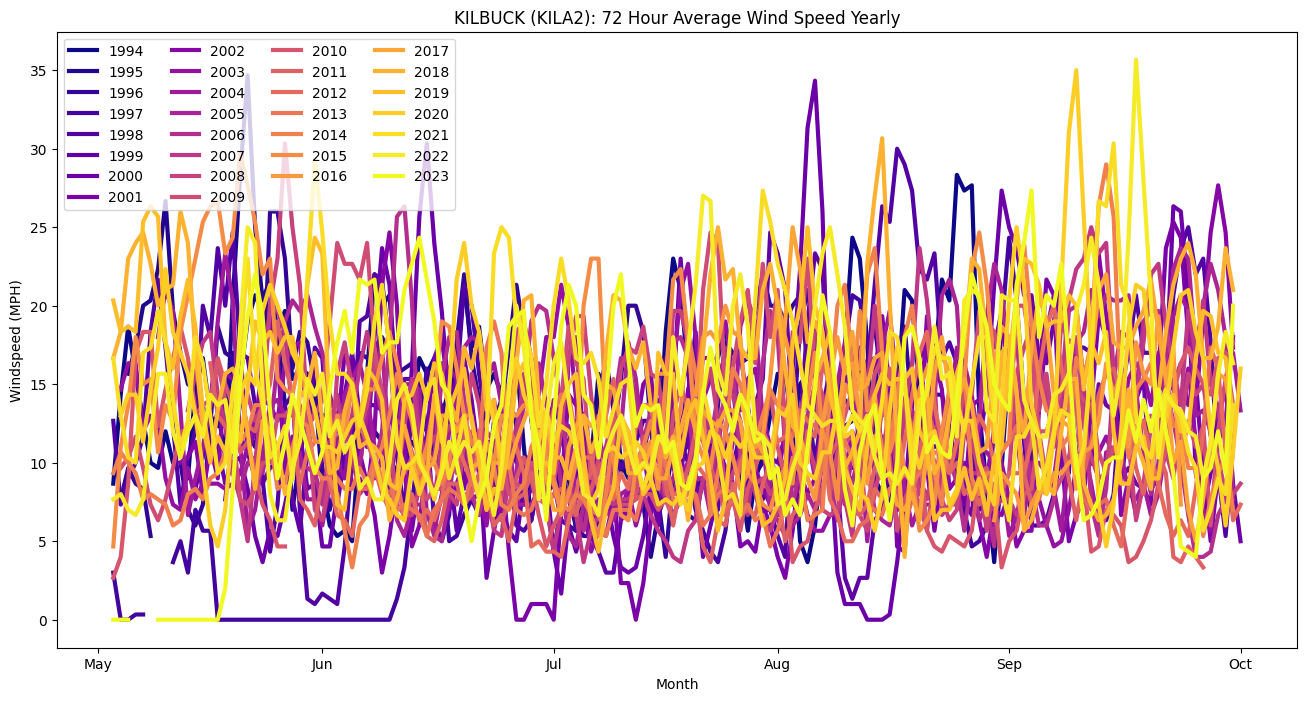

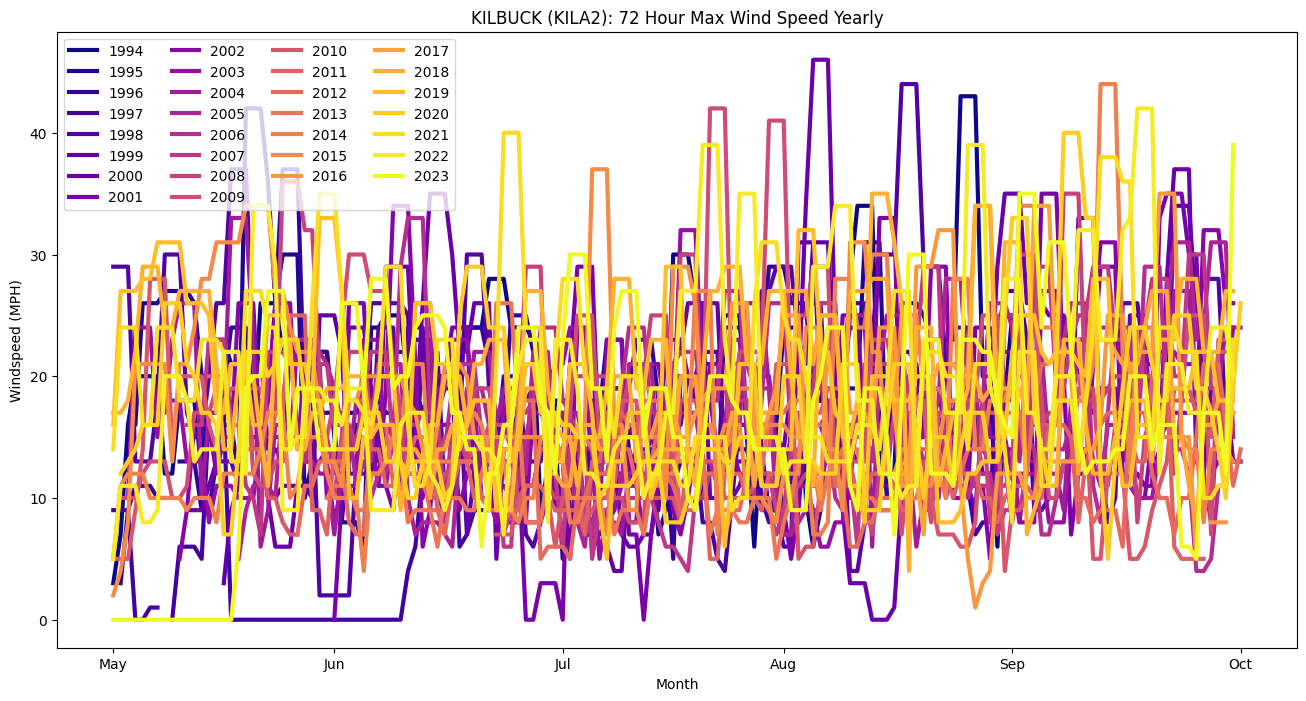

In [10]:
# Yearly Plots (Messy!)
# BUI Yearly Plots
df_bui_mean_yearly.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Build Up Index Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(ncol = columns)

# df_bui_max_yearly.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Build Up Index Yearly",figsize=figsize)
# plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
# plt.legend(ncol = columns)

#FWI Yearly Plts
# FWI Plots, Max and Average
# Average FWI Plot
df_fwi_yearly.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Fire Weather Index Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(ncol = columns)

# Max FWI Plot
# df_fwi_max_yearly.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Fire Weather Index Yearly",figsize=figsize)
# plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
# plt.legend(ncol = columns)

# Yearly Precip Plot
df_prec_yearly.plot(lw=3,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Accumulated Precipitation Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

# 24 and 72 Hour Precip Yearly

df_rain72hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Precipitation Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
df_rain24hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Precipitation Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

# Windspeeds 24 Hours, Yearly

# 24 Hour Max and Average windspeed
df_wind_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Average Wind Speed Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
# df_maxwind_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Max Wind Speed Yearly",figsize=figsize)
# plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
# plt.legend(loc="upper left", ncol = columns)

# Windspeeds 72 Hours, Yearly

# 72 Hour Rolling Averages and Maxes.
df_wind_72hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Average Wind Speed Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
df_maxwind_72hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Max Wind Speed Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)


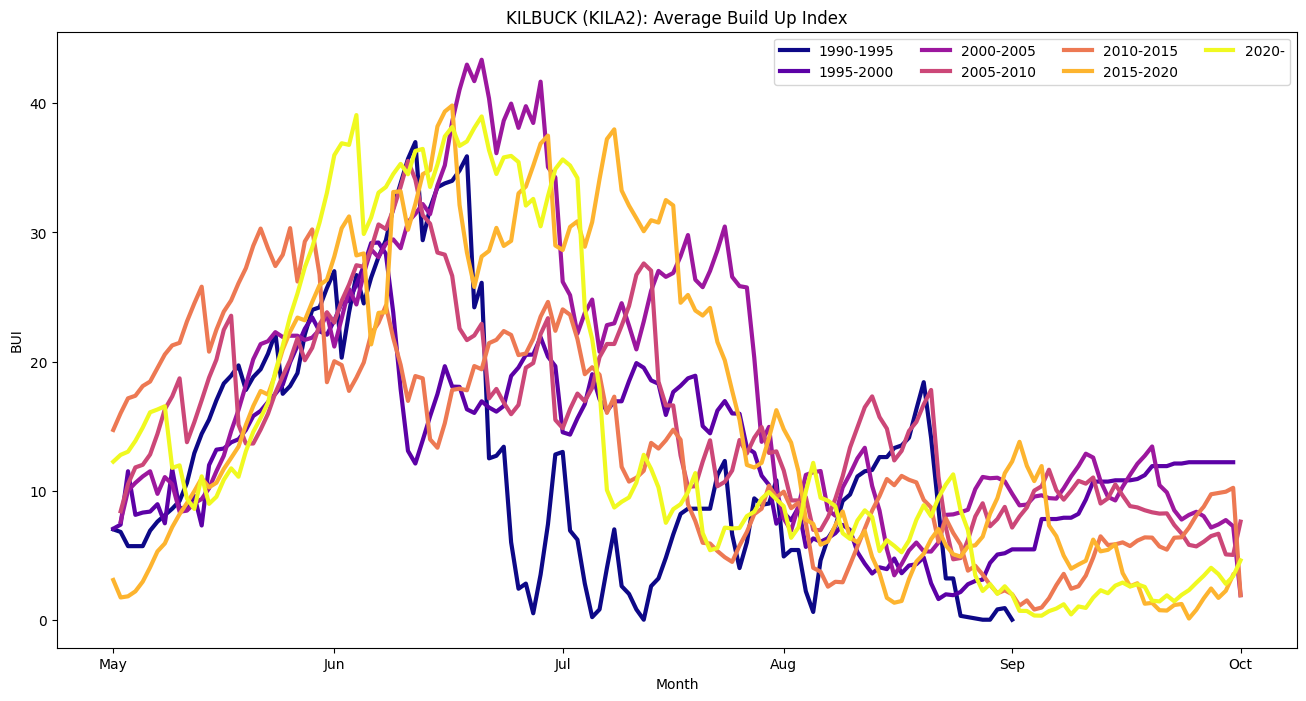

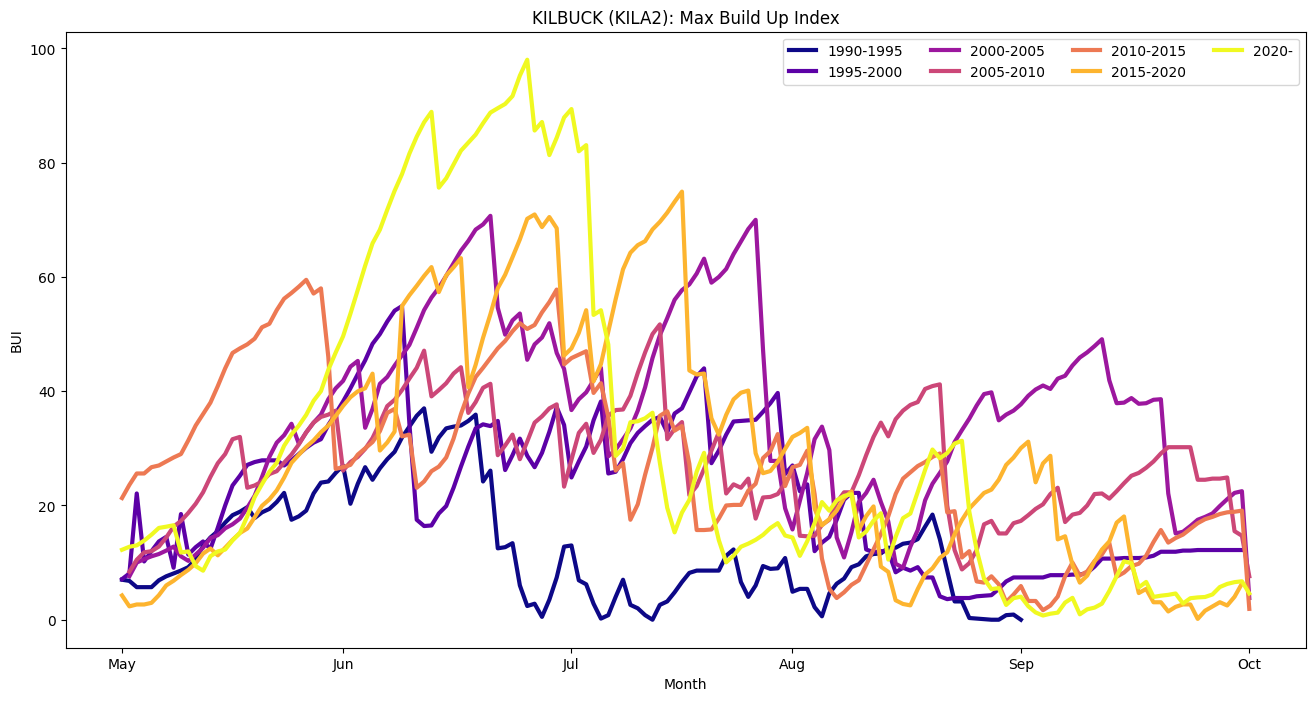

In [11]:
# Build Up Index Plots, max and Average
# Average Plot
df_pivot_bui_mean.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Build Up Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

# Max Plot
df_pivot_bui_max.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Build Up Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

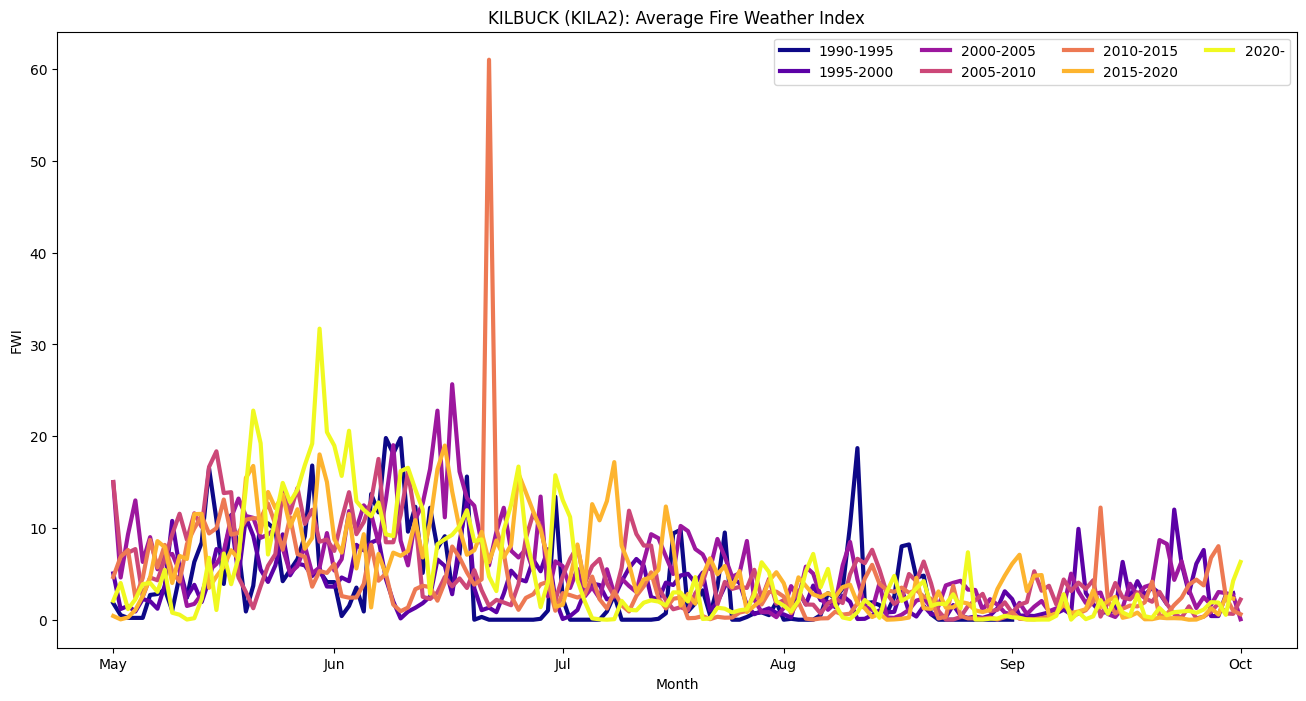

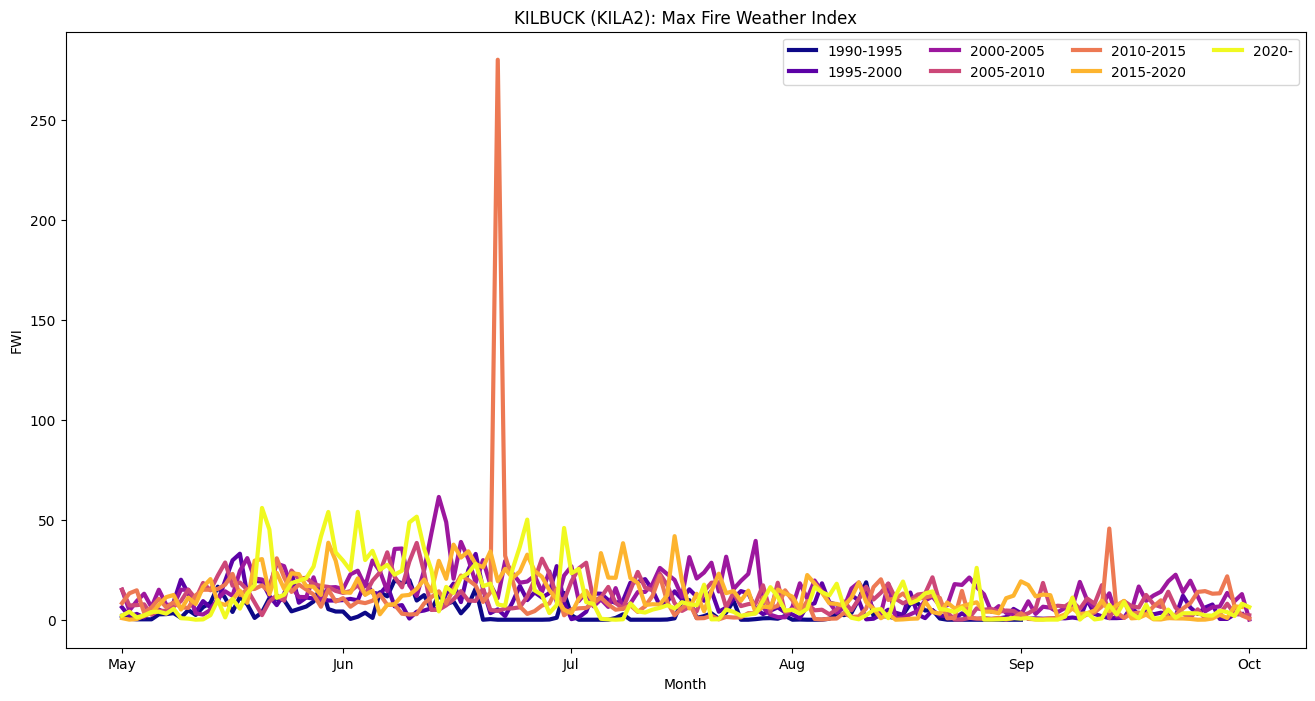

In [12]:
# FWI Plots, Max and Average
# Average FWI Plot
df_pivot_fwi.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Fire Weather Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

# Max FWI Plot
df_pivot_fwi_max.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Fire Weather Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

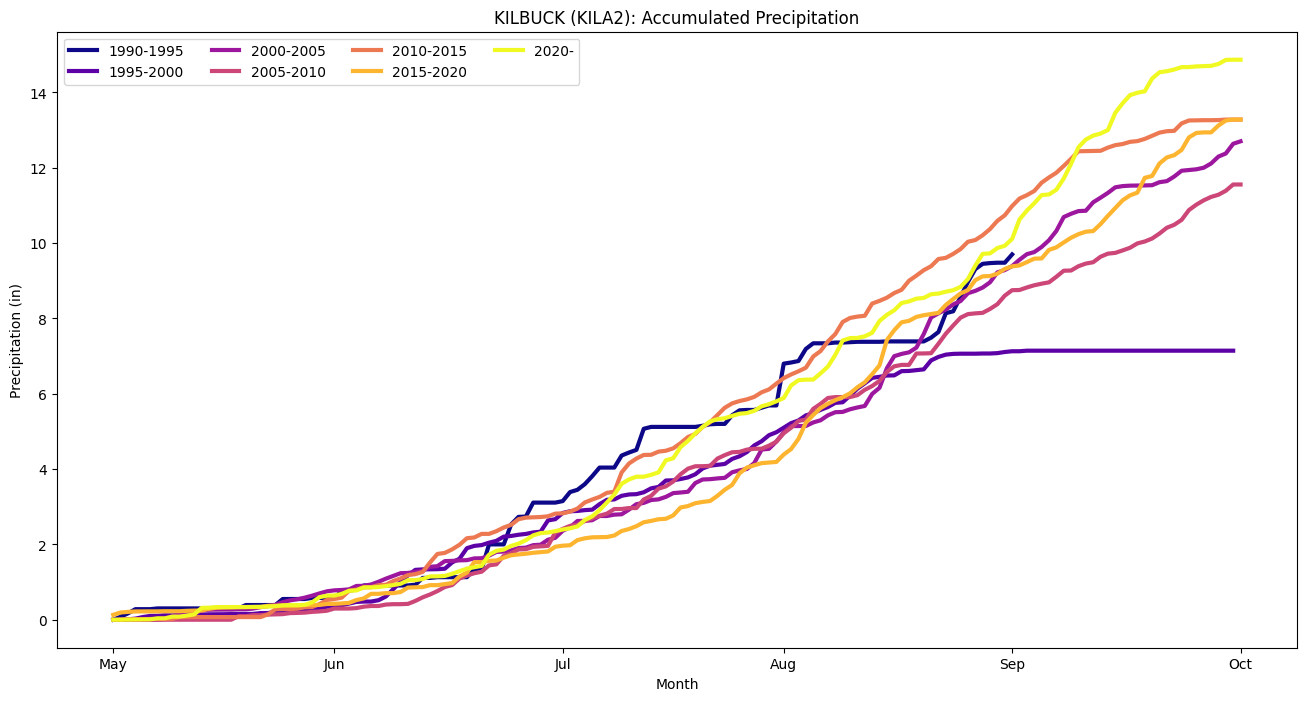

In [13]:
# Accumulated Precipitation Plot, When no data, stop graphing.
df_pivot.plot(lw=3,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Accumulated Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)


In [14]:
# df_pivot_solar.plot(lw=lw,colormap=colormap,ylabel='Solar Radiation (W/m**2)',xlabel='Month',legend='reverse',title="Average Solar Radiation",figsize=figsize)
# plt.xticks(np.linspace(121,274,6)[:-1], ('May','Jun','Jul','Aug','Sep'))
# plt.legend(legend,loc="upper left", ncol = columns)

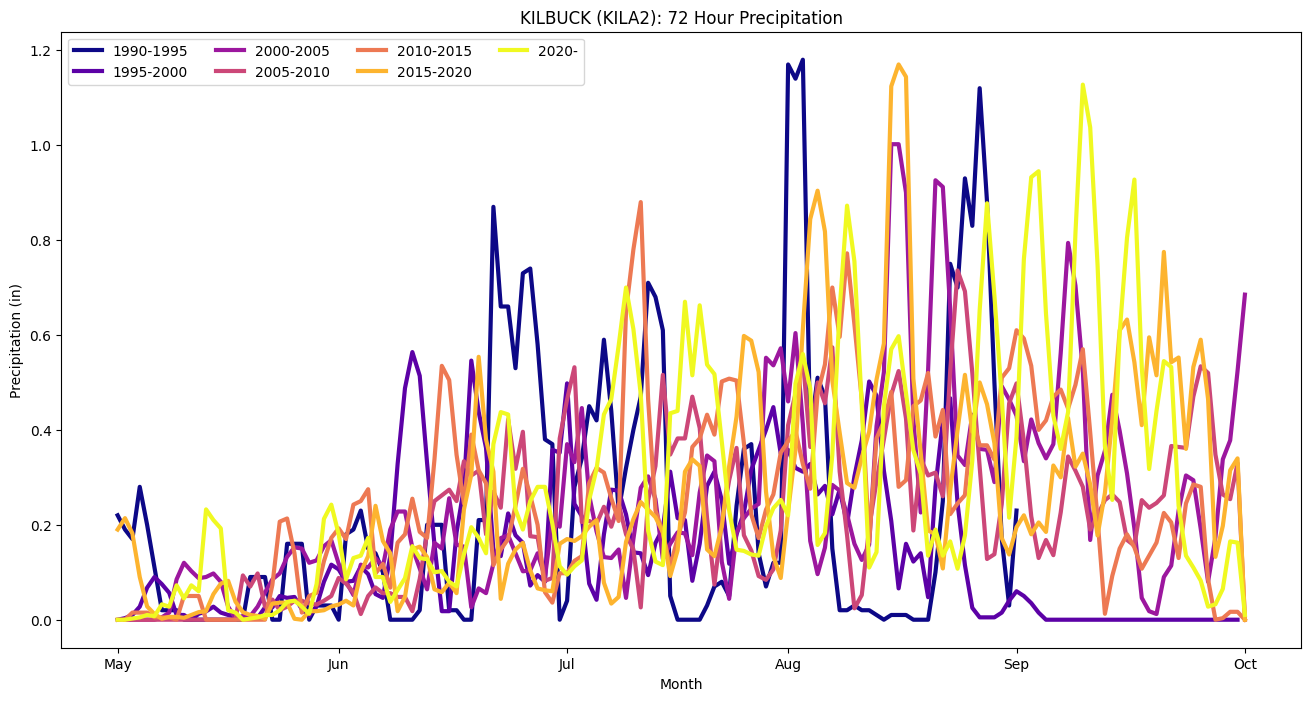

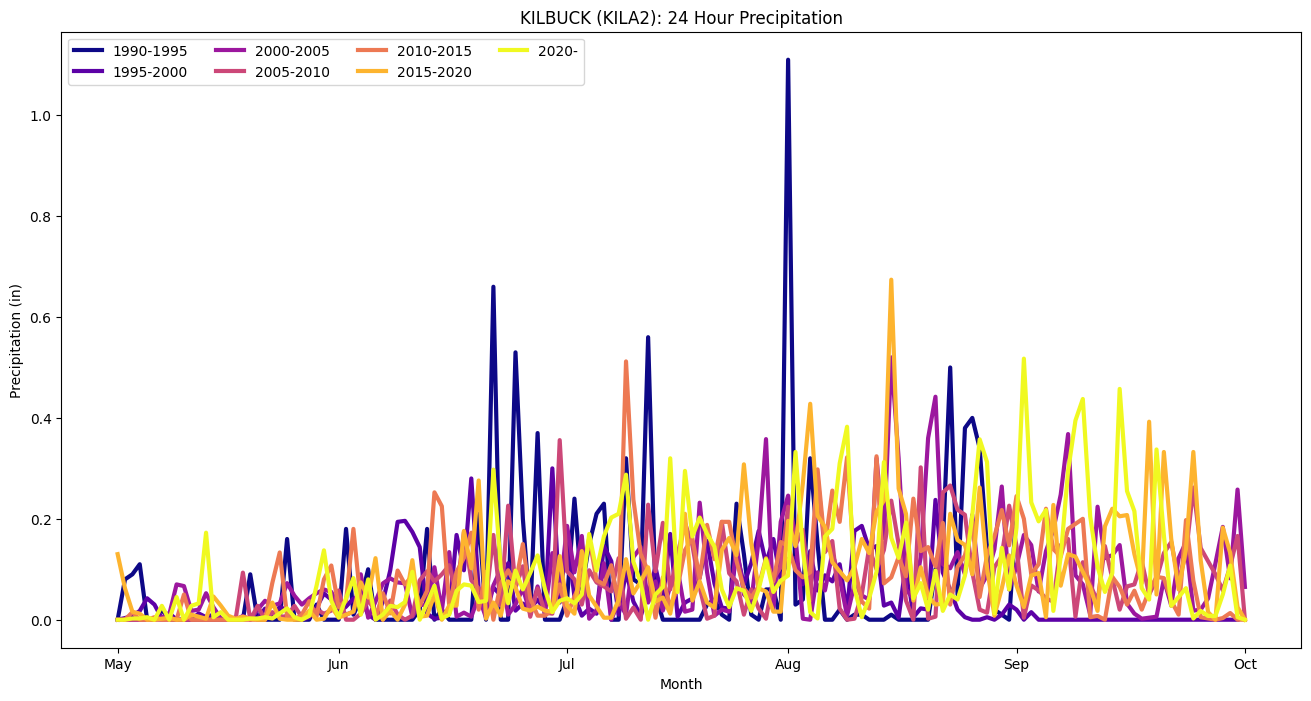

In [15]:
df_pivot_rain72hr.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)
df_pivot_rain24hr.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)

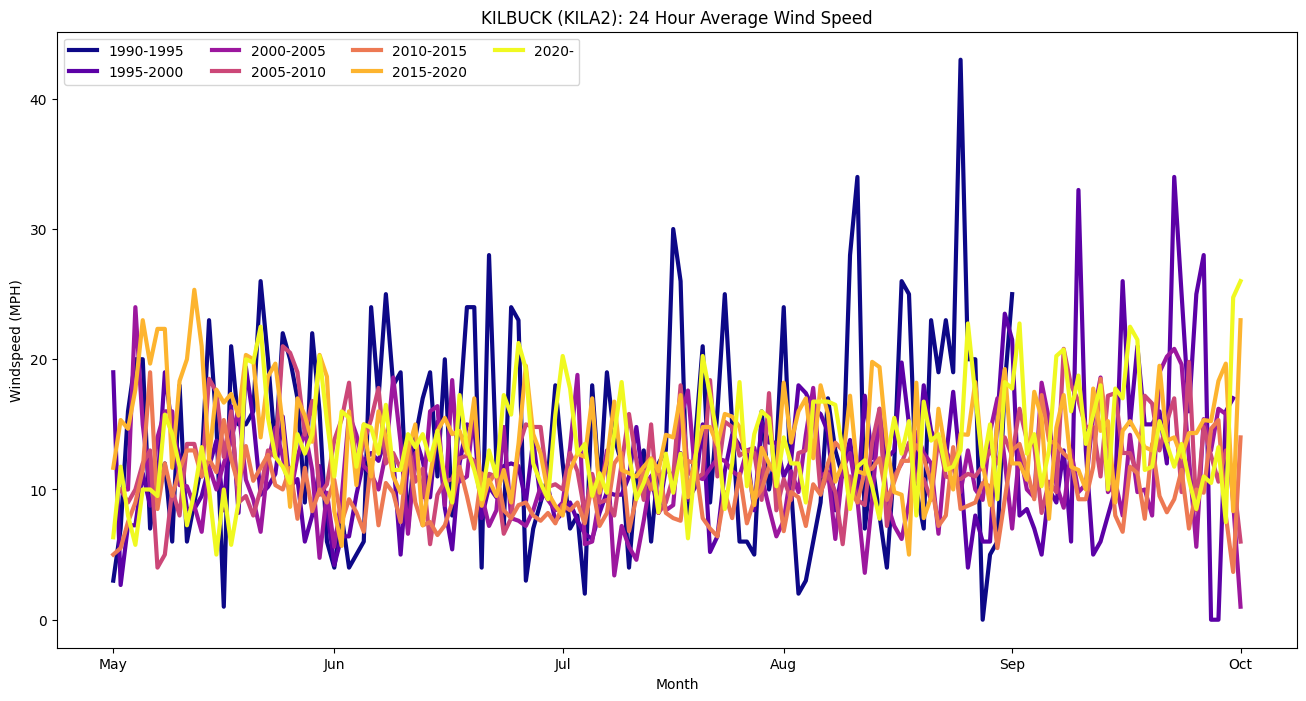

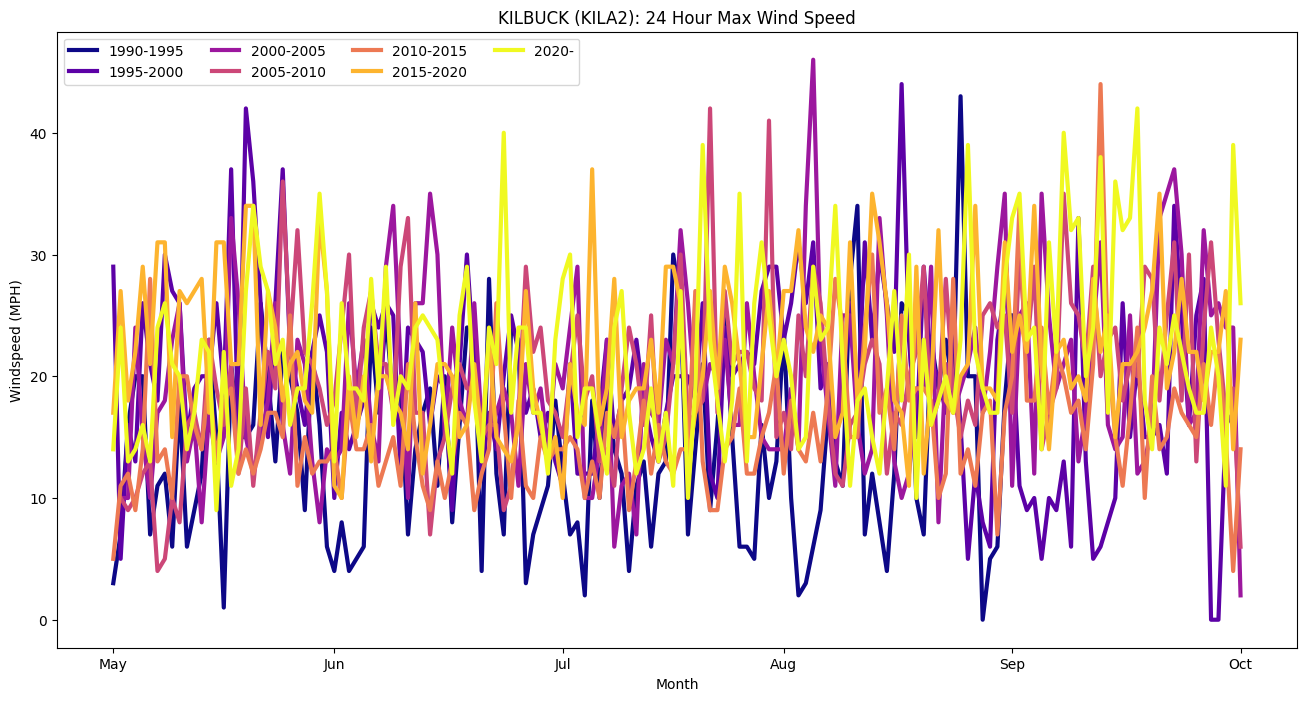

In [16]:
# 24 Hour Max and Average windspeed
df_pivot_wind.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Average Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)
df_pivot_maxwind.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Max Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)

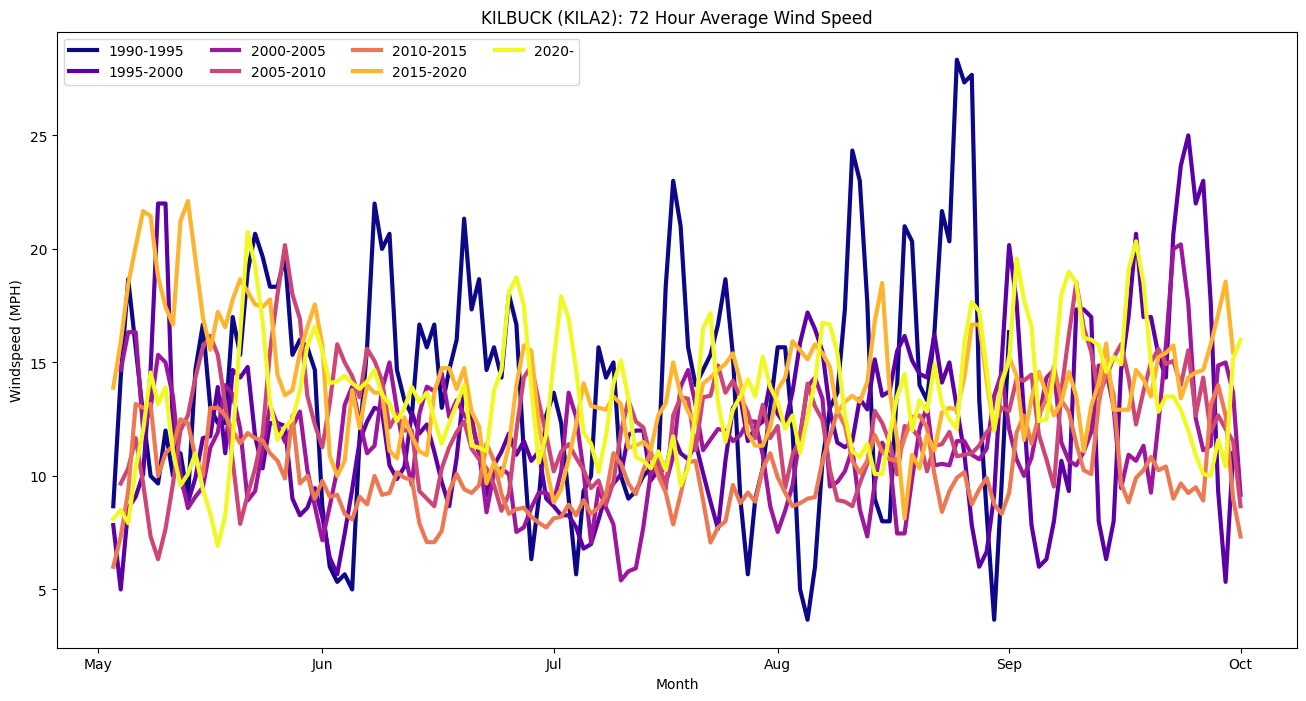

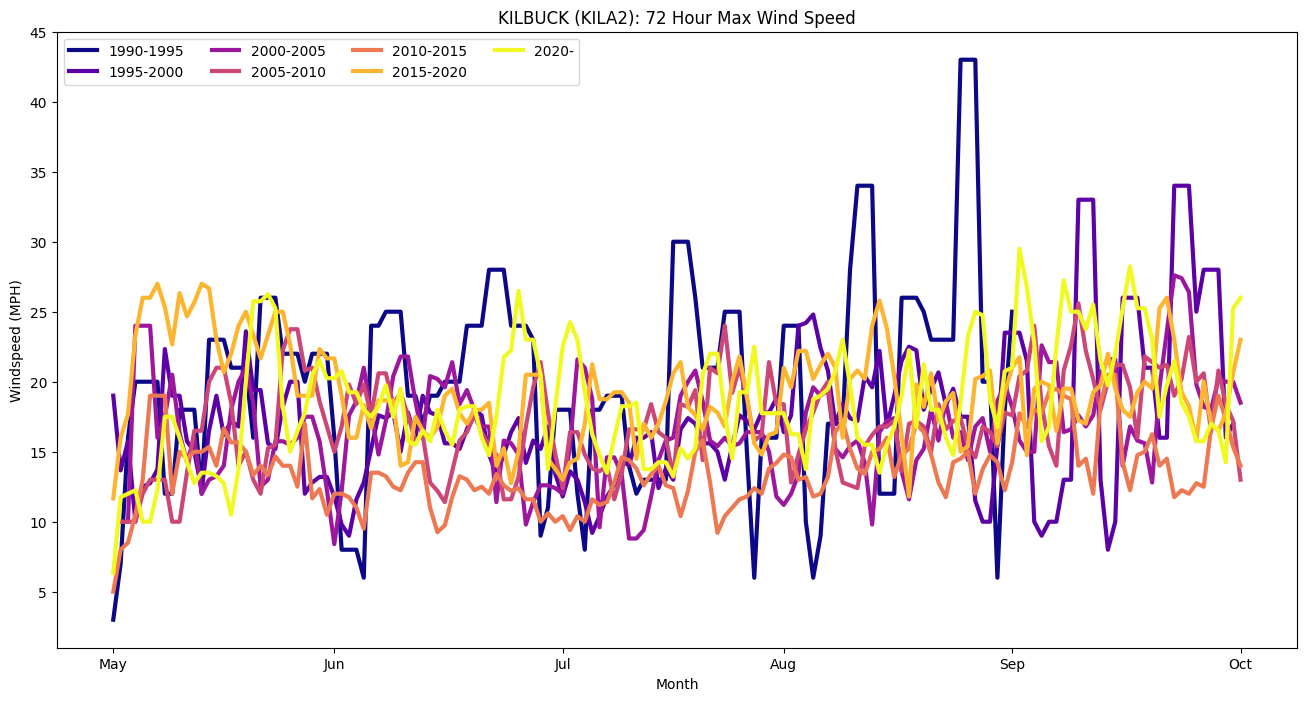

In [17]:
# 72 Hour Rolling Averages and Maxes.
df_pivot_wind_72hr.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Average Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)
df_pivot_maxwind_72hr.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Max Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)